In [1]:
import torch
import numpy as np
import os
import ast
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# ==========================================
# 1. 本地模型路径配置
# ==========================================
# 使用原始字符串 (r"") 避免 Windows 路径转义错误
QWEN3_RERANKER_PATH = r"D:\pythonProject\DeepSeek\SLOT-Qwen\Qwen3-Reranker-0.6B"
QWEN3_EMBEDDINGS_PATH = r"D:\pythonProject\DeepSeek\SLOT-Qwen\Qwen3-Embedding-0.6B"

class LocalIntelEngine:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"⚙️ 正在加载本地模型全家桶 (Device: {self.device})...")

        # 1. 加载 Embedding
        self.embed_model = SentenceTransformer(QWEN3_EMBEDDINGS_PATH, trust_remote_code=True)

        # 2. 加载 Reranker 分词器和模型
        self.rerank_tokenizer = AutoTokenizer.from_pretrained(QWEN3_RERANKER_PATH, trust_remote_code=True)
        self.rerank_model = AutoModelForSequenceClassification.from_pretrained(
            QWEN3_RERANKER_PATH, 
            trust_remote_code=True
        ).to(self.device).eval()

        # ==========================================
        # 🔧 核心修复逻辑：强行对齐 Padding
        # ==========================================
        # 如果没有定义 pad_token，则借用 eos_token (Qwen通常是 151643)
        if self.rerank_tokenizer.pad_token is None:
            self.rerank_tokenizer.pad_token = self.rerank_tokenizer.eos_token

        # 必须同时同步到模型的 config 中，否则 forward 过程会报错
        self.rerank_model.config.pad_token_id = self.rerank_tokenizer.pad_token_id

        # 强制指定分类头知道 pad_token
        self.rerank_model.resize_token_embeddings(len(self.rerank_tokenizer))
        # ==========================================

        print(f"✅ Qwen3 引擎修复完成！Pad Token ID: {self.rerank_model.config.pad_token_id}")

    def search_specific_risk(self, text, query, top_k_candidates=15):
        # 1. 切片防御
        chunks = self.chunk_text(text)
        if not chunks: 
            return "Error: No text chunks found"

        # 2. Step 1: 向量粗排
        try:
            # 确保转换成 tensor 并在计算后释放
            chunk_embeddings = self.embed_model.encode(chunks, convert_to_tensor=True)
            query_embedding = self.embed_model.encode([query], convert_to_tensor=True)

            cos_scores = torch.nn.functional.cosine_similarity(query_embedding, chunk_embeddings)

            # 动态调整 top_k，防止超出数组范围
            actual_k = min(top_k_candidates, len(chunks))
            top_results = torch.topk(cos_scores, k=actual_k)

            candidates = [chunks[i] for i in top_results.indices]

            # 如果依然没有候选，直接返回
            if not candidates:
                return "No relevant candidates found in vector search"

            # 3. Step 2: Reranker 精排
            pairs = [[query, doc] for doc in candidates]
            with torch.no_grad():
                inputs = self.rerank_tokenizer(
                    pairs, 
                    padding=True, 
                    truncation=True, 
                    return_tensors='pt', 
                    max_length=512
                ).to(self.device)

                outputs = self.rerank_model(**inputs)
                # 再次确认维度
                logits = outputs.logits.view(-1).float()

                # 这里的 argmax 索引一定是相对于 candidates 的
                best_idx = torch.argmax(logits).item()

                # 防御性返回
                if best_idx < len(candidates):
                    return candidates[best_idx].strip()
                else:
                    return candidates[0].strip() # 兜底逻辑

        except Exception as e:
            return f"Search Error: {str(e)}"

    def chunk_text(self, text, chunk_size=600, overlap=150):
        """
        针对金融文本优化切片逻辑。
        600 tokens 左右通常包含完整的上下文和数据点。
        """
        if not text or len(text) < 100: return []
        return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size-overlap)]


# ==========================================
# 2. 实战应用：多维度“红旗”扫描器
# ==========================================
def scan_company_red_flags(engine, full_text):
    """
    针对给定的财报文本，扫描预定义的金融风险点
    """
    audit_queries = {
        "inventory_risk": "inventory backlog, write-down, or slow-moving stock issues",
        "regulatory_risk": "government investigation, SEC inquiry, or compliance penalties",
        "china_market": "revenue decline in China, geopolitical tensions, or market competition in Asia",
        "debt_liquidity": "liquidity concerns, debt refinancing, or interest rate pressure"
    }

    findings = {}
    for flag, query in audit_queries.items():
        # print(f"🔍 Scanning for {flag}...")
        findings[flag] = engine.search_specific_risk(full_text, query)

    return findings

# 初始化引擎
engine = LocalIntelEngine()

⚙️ 正在加载本地模型全家桶 (Device: cuda)...


Some weights of Qwen3ForSequenceClassification were not initialized from the model checkpoint at D:\pythonProject\DeepSeek\SLOT-Qwen\Qwen3-Reranker-0.6B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Qwen3 引擎修复完成！Pad Token ID: 151643


In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设置字体与专业风格 (MiSans)
plt.rcParams['font.sans-serif'] = ['MiSans', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="white", font='MiSans')

# 2. 数据处理
df = pd.read_csv('master_financial_intel_v2.csv')

def get_risk_count(x):
    try:
        items = ast.literal_eval(x)
        return len(items) if isinstance(items, list) else 0
    except: return 0

df['risk_count'] = df['risk_flags'].apply(get_risk_count)
# 风险密度公式：风险项越多、情绪越乐观，得分越高（代表背离越严重）
# 加 1.1 是为了将情绪分归一化到正数区间并避免除以零
df['risk_density'] = df['risk_count'] / (df['company_sentiment'] + 1.1)

In [ ]:
# ==========================================
# 3. 自动化审计：针对高危公司提取“原始证据”
# ==========================================

# 1. 筛选出需要“深度审计”的公司 (例如风险密度前 5 的公司)
# 假设你已经运行了之前的 df['risk_density'] 计算
top_risk_companies = df.sort_values('risk_density', ascending=False).head(30)['company'].tolist()

print(f"🚨 正在对以下高危公司进行本地原始证据扫描: {top_risk_companies}")

audit_results = []
BASE_PATH = "./cleaned_ECTs_dataset"
for company in top_risk_companies:
    # 找到该公司的原始 txt 文件路径
    # 假设你的原始文件在 BASE_PATH 下的各公司子文件夹里
    company_dir = os.path.join(BASE_PATH, company)
    files = [f for f in os.listdir(company_dir) if f.endswith('.txt')]
    if not files: continue
    
    latest_file = os.path.join(company_dir, sorted(files)[-1])
    with open(latest_file, 'r', encoding='utf-8') as f:
        full_text = f.read()

    # 使用本地引擎搜索“最致命”的细节
    # 我们可以定义几个狙击目标
    targets = {
        "供应链瓶颈": "supply chain constraints, manufacturing delays, components shortage",
        "竞争压力": "competitive intensity, market share loss, pricing pressure from rivals",
        "地缘政治": "geopolitical tensions, export controls, trade restrictions, China market risks"
    }
    
    company_evidence = {"company": company}
    for label, query in targets.items():
        evidence = engine.search_specific_risk(full_text, query)
        company_evidence[label] = evidence
        
    audit_results.append(company_evidence)

# 转换为 DataFrame 查看
df_audit = pd.DataFrame(audit_results)
print("\n✅ 审计完成！已提取本地原始证据。")
display(df_audit)

🚨 正在对以下高危公司进行本地原始证据扫描: ['Citi', 'Nike', 'Airbus', 'Lululemon', 'Microsoft']

✅ 审计完成！已提取本地原始证据。


,company,供应链瓶颈,竞争压力,地缘政治
0,Citi,"ind as we identify those areas, being able to ...",- obviously in U.S. Personal Banking and in se...,e that we don't like start [ mind ] this into ...
1,Nike,"erenced, some of the channel mix headwinds, th...","is quarter, in particular, we took a big step ...",d dig in a little bit more on the China busine...
2,Airbus,ly 3 months have passed since we last met at t...,large and quite good type of campaigns. We see...,bad contracts have already been provisioned fo...
3,Lululemon,ed a notable slowdown. The root cause was iden...,pportunity to continue to grow that meaningful...,aided brand awareness. And we know that the st...
4,Microsoft,"kspace design system, which now, for example, ...",n of the kit happens when we have the demand s...,"number given the scale of Azure, but it did co..."


In [17]:
df_audit

,company,供应链瓶颈,竞争压力,地缘政治
0,Citi,"ind as we identify those areas, being able to ...",- obviously in U.S. Personal Banking and in se...,e that we don't like start [ mind ] this into ...
1,Nike,"erenced, some of the channel mix headwinds, th...","is quarter, in particular, we took a big step ...",d dig in a little bit more on the China busine...
2,Airbus,ly 3 months have passed since we last met at t...,large and quite good type of campaigns. We see...,bad contracts have already been provisioned fo...
3,Lululemon,ed a notable slowdown. The root cause was iden...,pportunity to continue to grow that meaningful...,aided brand awareness. And we know that the st...
4,Microsoft,"kspace design system, which now, for example, ...",n of the kit happens when we have the demand s...,"number given the scale of Azure, but it did co..."


In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# ==========================================
# 1. 加载 Instruct 审计引擎
# ==========================================
model_path = r"D:\pythonProject\DeepSeek\DIM\Qwen3-4B-Instruct-2507"

print("🧠 正在加载 Qwen3-4B-Instruct 审计专家...")
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16, # 24G显存建议用 bf16
    trust_remote_code=True
)

# 使用你喜欢的编译优化
# model = torch.compile(model)

print("✅ 审计专家已就位。")

# ==========================================
# 2. 核心逻辑：自动打脸检测（Audit Logic）
# ==========================================
def perform_audit(company_name, api_sentiment, local_evidence):
    """
    对比 DeepSeek 的宏观情绪评分与本地抓取的硬证据
    """
    prompt = f"""你是一个苛刻的对冲基金合规官。请对比以下【管理层态度】与【实际风险证据】，判断是否存在“粉饰太平”的嫌疑。

【公司】：{company_name}
【DeepSeek 提取的情绪分】：{api_sentiment} (1.0最乐观，-1.0最悲观)
【本地 RAG 抓取的原始证据】：
- 供应链证据: {local_evidence.get('供应链瓶颈', '未发现')}
- 竞争压力证据: {local_evidence.get('竞争压力', '未发现')}
- 地缘政治证据: {local_evidence.get('地缘政治', '未发现')}

任务：
1. 冲突检测：如果情绪分为正（乐观），但证据中包含罢工、产能受限或市场丢失等硬伤，请指出矛盾点。
2. 诚信评分：给出 0-10 的“言行一致性评分”（10为完全透明，0为严重误导）。
3. 审计结论：用一句话总结该公司是否值得警惕。

请严格按此格式回复：
[冲突点]: 
[一致性得分]: 
[最终结论]: 
"""

    messages = [
            {"role": "system", "content": "你是一个专业的金融审计专家。"},
            {"role": "user", "content": prompt}
        ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # 核心修改：这里需要 return_tensors='pt' 并确保 mask 也被获取
    inputs = tokenizer(text, return_tensors="pt", padding=True).to(model.device)

    # 核心修改：在 generate 中显式传入 attention_mask
    generated_ids = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask, # 传入 mask
        max_new_tokens=512,
        do_sample=False,  # 审计任务建议关闭采样，保证确定性
        pad_token_id=tokenizer.pad_token_id
    )

    # 修复：只解码新生成的部分，避免包含输入的 prompt
    response = tokenizer.decode(generated_ids[0][inputs.input_ids.shape[-1]:], skip_special_tokens=True)

    return response

🧠 正在加载 Qwen3-4B-Instruct 审计专家...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 审计专家已就位。


In [6]:
# 示例：审计 Nike
nike_sentiment = df[df['company'] == 'Nike']['company_sentiment'].values[0]
nike_evidence = df_audit[df_audit['company'] == 'Nike'].to_dict('records')[0]

audit_report = perform_audit('Nike', nike_sentiment, nike_evidence)
print(f"🕵️ AlphaQuest 审计报告 - Nike:\n")
print(audit_report)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🕵️ AlphaQuest 审计报告 - Nike:

[冲突点]:  
情绪分-0.2（略偏悲观）本应反映谨慎态度，但管理层表述中存在明显“粉饰”迹象：一方面声称“我们正在主动缩减表现不佳的产品线，以重新调整业务结构”，并强调“我们正在采取积极措施将业务回归合理轨道”，这属于典型的乐观叙事；另一方面，证据明确指出“供应链去杠杆”“产品成本效益减弱”“战略定价措施的收益下降”“东海岸表现疲软”“中国渠道客流疲软”“库存压力”“行业整体承压”等硬伤，且明确指出“预计全年中位数单数字收入压力”，说明基本面存在持续性下行风险。然而，管理层将这些负面因素归因于“阶段性调整”或“过渡期”，并用“积极管理”“逐步改善”等语言掩盖结构性问题，形成“情绪乐观但证据悲观”的明显矛盾，构成“粉饰太平”嫌疑。

[一致性得分]: 3  
（仅因情绪分略偏悲观，未达最悲观，但证据中存在大量结构性风险，且管理层用积极语言包装负面现实，存在明显信息选择性与语言美化，故评分偏低）

[最终结论]: Nike管理层存在显著粉饰太平嫌疑，其乐观情绪与实际供应链、竞争、地缘政治压力严重不符，值得高度警惕。


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18100\2927274493.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='consistency', y='company', palette='RdYlGn')


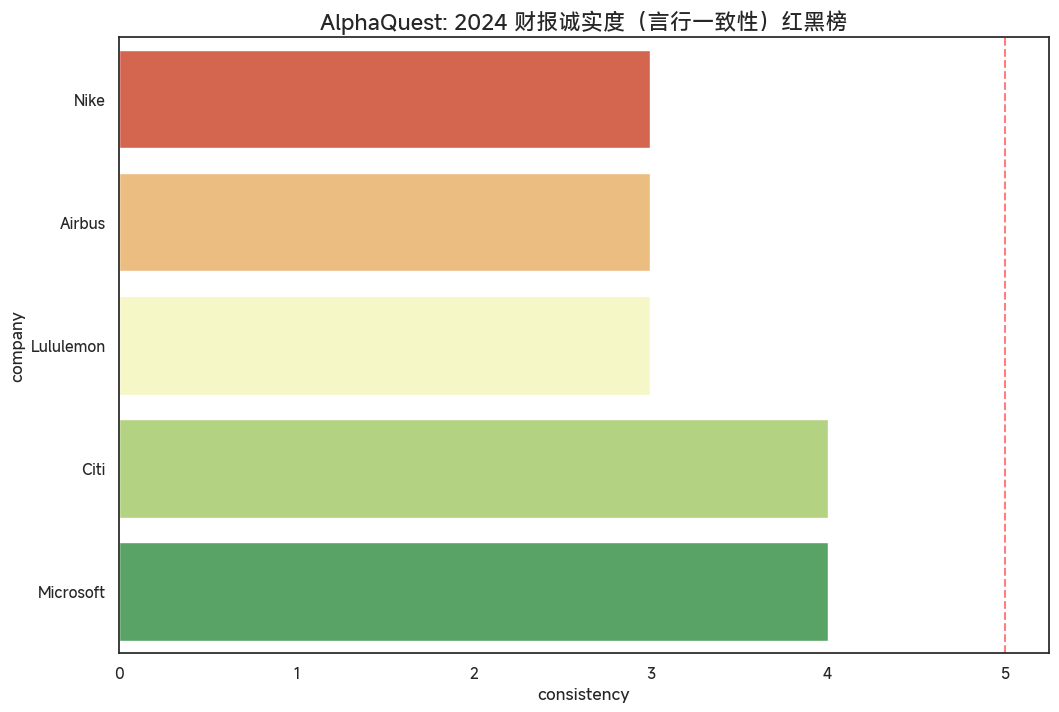

In [ ]:
# ==========================================
# 4. 自动化：全量审计与红黑榜生成
# ==========================================
all_audit_reports = []

# 遍历之前提取好证据的 df_audit
for _, row in df_audit.iterrows():
    company = row['company']
    # 从原始 df 中获取 DeepSeek 给出的情绪分
    api_sent = df[df['company'] == company]['company_sentiment'].values[0]
    
    # 执行本地 4B 审计
    report_text = perform_audit(company, api_sent, row)
    
    # 使用正则表达式或简单的字符串处理提取分数 (假设格式固定)
    try:
        score = int(report_text.split("[一致性得分]:")[1].split()[0])
    except:
        score = 5 # 默认中间分
        
    all_audit_reports.append({
        "company": company,
        "sentiment": api_sent,
        "consistency": score,
        "report": report_text
    })

df_final = pd.DataFrame(all_audit_reports)



In [16]:
df_final

,company,sentiment,consistency,report,sentiment_adjusted,correction_gap
1,Nike,-0.2,3,[冲突点]: \n情绪分-0.2（略偏悲观）本应反映谨慎态度，但管理层表述中存在明显“粉饰...,-0.06,-0.14
2,Airbus,0.4,3,[冲突点]: \n尽管DeepSeek情绪分为0.4（偏乐观），但实际证据中明确指出“供应...,0.12,0.28
3,Lululemon,0.4,3,[冲突点]: \n尽管DeepSeek情绪分为0.4（偏乐观），但供应链证据明确指出“产品...,0.12,0.28
0,Citi,0.4,4,[冲突点]: \n尽管DeepSeek提取的情绪分为0.4（偏乐观），但本地RAG抓取的原...,0.16,0.24
4,Microsoft,0.8,4,[冲突点]: \n尽管DeepSeek提取的情绪分为0.8（高度乐观），但本地RAG抓取的...,0.32,0.48


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18100\801747923.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='consistency', y='company', palette='RdYlGn')


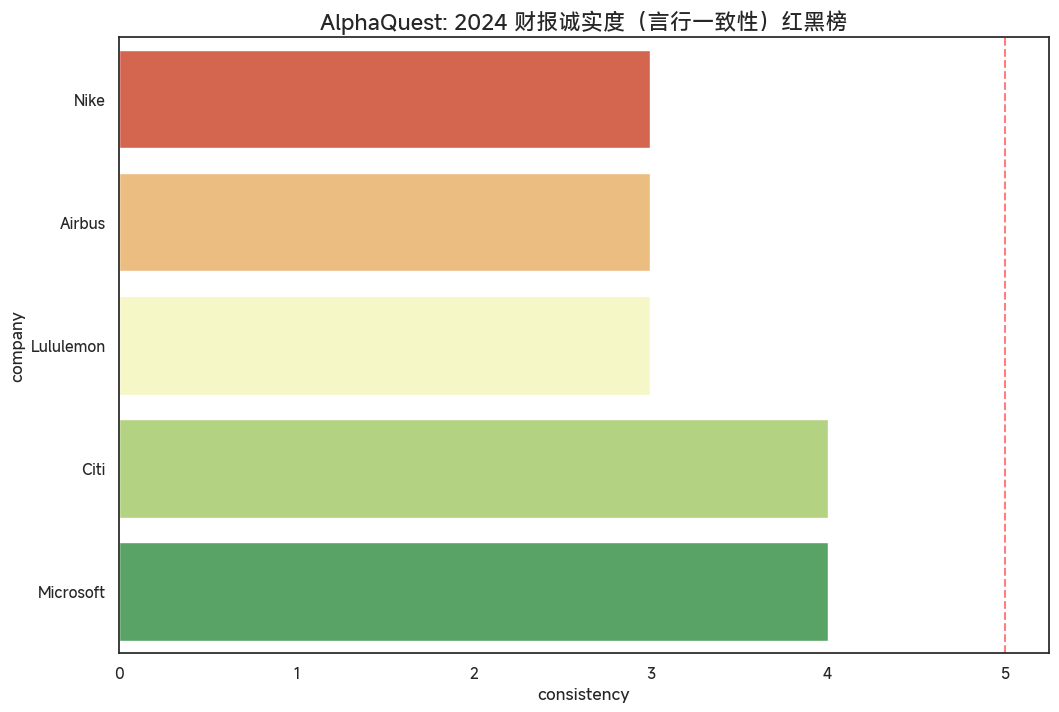

In [8]:
# 可视化：诚实度排行
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
# 颜色越红代表越值得警惕（一致性低），颜色越绿代表越透明
df_final = df_final.sort_values('consistency')
sns.barplot(data=df_final, x='consistency', y='company', palette='RdYlGn')
plt.title('AlphaQuest: 2024 财报诚实度（言行一致性）红黑榜', fontsize=16)
plt.axvline(5, color='red', ls='--', alpha=0.5) # 预警线
plt.show()

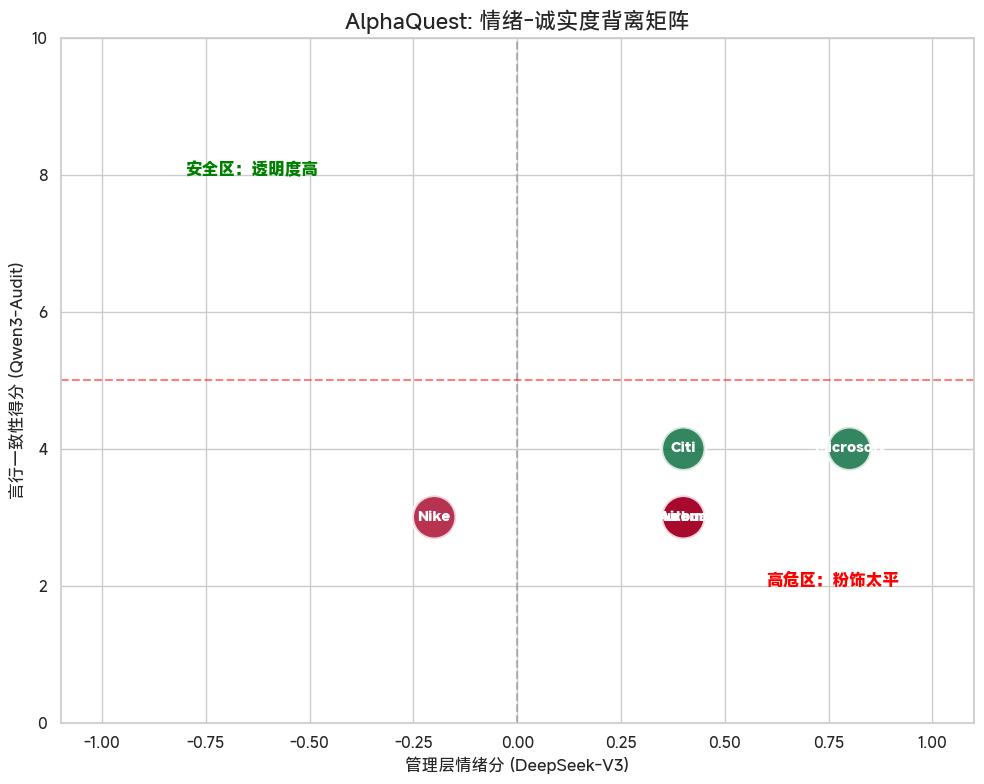

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 数据整理 (基于你刚才的输出)
data = {
    'Company': ['Nike', 'Airbus', 'Lululemon', 'Citi', 'Microsoft'],
    'Sentiment': [-0.2, 0.4, 0.4, 0.4, 0.8],
    'Consistency': [3, 3, 3, 4, 4]
}
plot_df = pd.DataFrame(data)

plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid", font='MiSans')

# 绘制散点图
ax = sns.scatterplot(data=plot_df, x='Sentiment', y='Consistency', 
                     hue='Consistency', palette='RdYlGn', s=1000, alpha=0.8, legend=False)

# 标注公司名
for i, row in plot_df.iterrows():
    plt.text(row['Sentiment'], row['Consistency'], row['Company'], 
             ha='center', va='center', color='white', fontweight='bold', fontsize=10)

# 划分区间
plt.axvline(0, color='grey', ls='--', alpha=0.5)
plt.axhline(5, color='red', ls='--', alpha=0.5)

plt.title('AlphaQuest: 情绪-诚实度背离矩阵', fontsize=16)
plt.xlabel('管理层情绪分 (DeepSeek-V3)', fontsize=12)
plt.ylabel('言行一致性得分 (Qwen3-Audit)', fontsize=12)
plt.xlim(-1.1, 1.1)
plt.ylim(0, 10)

# 添加注释
plt.text(0.6, 2, "高危区：粉饰太平", color='red', fontsize=12, fontweight='bold')
plt.text(-0.8, 8, "安全区：透明度高", color='green', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 计算量化特征：诚信加权情绪分
df_final['sentiment_adjusted'] = df_final['sentiment'] * (df_final['consistency'] / 10)

# 2. 计算“修正缺口” (Correction Gap)
# 缺口越大，代表该公司的情绪分“水分”越多
df_final['correction_gap'] = df_final['sentiment'] - df_final['sentiment_adjusted']

# 3. 按照修正后的分数重新排序
df_ranked = df_final.sort_values('sentiment_adjusted', ascending=False).copy()

print("✅ 量化特征 $S_{adjusted}$ 计算完成。")
display(df_ranked[['company', 'sentiment', 'consistency', 'sentiment_adjusted', 'correction_gap']])

✅ 量化特征 $S_{adjusted}$ 计算完成。


,company,sentiment,consistency,sentiment_adjusted,correction_gap
4,Microsoft,0.8,4,0.32,0.48
0,Citi,0.4,4,0.16,0.24
2,Airbus,0.4,3,0.12,0.28
3,Lululemon,0.4,3,0.12,0.28
1,Nike,-0.2,3,-0.06,-0.14


In [29]:
df_ranked[['company', 'sentiment', 'consistency', 'sentiment_adjusted', 'correction_gap']]

,company,sentiment,consistency,sentiment_adjusted,correction_gap
4,Microsoft,0.8,4,0.32,0.48
0,Citi,0.4,4,0.16,0.24
2,Airbus,0.4,3,0.12,0.28
3,Lululemon,0.4,3,0.12,0.28
1,Nike,-0.2,3,-0.06,-0.14


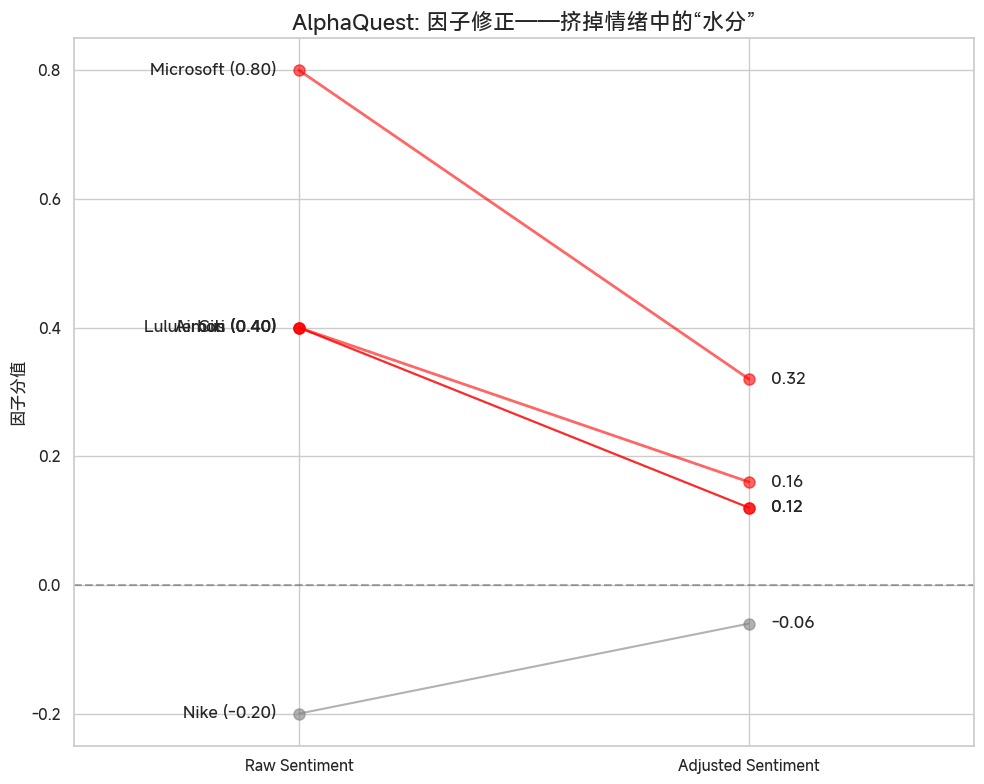

In [14]:
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid", font='MiSans')

# 绘制原始情绪 vs 修正情绪的对比
for i, row in df_ranked.iterrows():
    # 绘制连接线
    color = 'red' if row['correction_gap'] > 0.2 else 'grey'
    plt.plot(['Raw Sentiment', 'Adjusted Sentiment'], 
             [row['sentiment'], row['sentiment_adjusted']], 
             marker='o', markersize=8, color=color, alpha=0.6, linewidth=row['consistency']/2)
    
    # 添加公司标签
    plt.text(-0.05, row['sentiment'], f"{row['company']} ({row['sentiment']:.2f})", ha='right', va='center')
    plt.text(1.05, row['sentiment_adjusted'], f"{row['sentiment_adjusted']:.2f}", ha='left', va='center')

plt.title('AlphaQuest: 因子修正——挤掉情绪中的“水分”', fontsize=16)
plt.ylabel('因子分值', fontsize=12)
plt.xlim(-0.5, 1.5)
plt.axhline(0, color='black', ls='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# 转换为多因子矩阵格式：Date, Ticker, Factor_Value
export_df = df_ranked[['company', 'sentiment_adjusted']].copy()
export_df['date'] = pd.to_datetime('2024-12-18') # 假设为当前财报发布日期
export_df.columns = ['ticker', 'alpha_factor', 'date']

export_df.to_csv('alpha_quest_factors.csv', index=False)
print("📂 因子数据已导出，可直接输入回测引擎。")

📂 因子数据已导出，可直接输入回测引擎。


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# ==========================================
# 1. 准备审计后的数据集 (基于你之前的分析结果)
# ==========================================
audit_data = {
    'company': ['Nike', 'Airbus', 'Lululemon', 'Citi', 'Microsoft'],
    'ticker': ['NKE', 'AIR.PA', 'LULU', 'C', 'MSFT'],
    'sentiment_raw': [-0.2, 0.4, 0.4, 0.4, 0.8],
    'consistency': [3, 3, 3, 4, 4]
}

df_alpha = pd.DataFrame(audit_data)

# 计算诚信修正分 (S_adjusted)
df_alpha['sentiment_adj'] = df_alpha['sentiment_raw'] * (df_alpha['consistency'] / 10)

# ==========================================
# 2. 自动抓取 30 天市场表现 (2025-11-18 到 2025-12-18)
# ==========================================
# ==========================================
# 2. 自动抓取 30 天市场表现 (修复版)
# ==========================================
import yfinance as yf

print("📈 正在同步真实市场数据...")

# 稍微拉长时间窗口以确保能抓到起始价格（防止遇到非交易日）
start_date = "2025-11-15" 
end_date = "2025-12-15"
tickers = df_alpha['ticker'].tolist()

# 核心修改 1：下载全量数据，不带后缀索引
raw_data = yf.download(tickers, start=start_date, end=end_date)

# 核心修改 2：检查列名，优先使用 Adj Close，备选 Close
if 'Adj Close' in raw_data.columns:
    price_df = raw_data['Adj Close']
else:
    price_df = raw_data['Close']

print(f"✅ 成功抓取数据，包含列: {list(price_df.columns)}")

📈 正在同步真实市场数据...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18100\3922264451.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed

✅ 成功抓取数据，包含列: ['AIR.PA', 'C', 'LULU', 'MSFT', 'NKE']


In [27]:
df_alpha

,company,ticker,sentiment_raw,consistency,sentiment_adj,real_return_30d
0,Nike,NKE,-0.2,3,-0.06,-2.835296
1,Airbus,AIR.PA,0.4,3,0.12,28.501951
2,Lululemon,LULU,0.4,3,0.12,-45.582223
3,Citi,C,0.4,4,0.16,46.801730
4,Microsoft,MSFT,0.8,4,0.32,13.077341


📊 NKE: -2.84%
📊 AIR.PA: 28.50%
📊 LULU: -45.58%
📊 C: 46.80%
📊 MSFT: 13.08%

📊 相关性报告:
| 因子类型 | 相关系数 (R) | 显著性 (P-Value) |
| :--- | :--- | :--- |
| 原始情绪因子 | 0.1696 | 0.7851 |
| 诚信修正因子 | 0.2375 | 0.7005 |


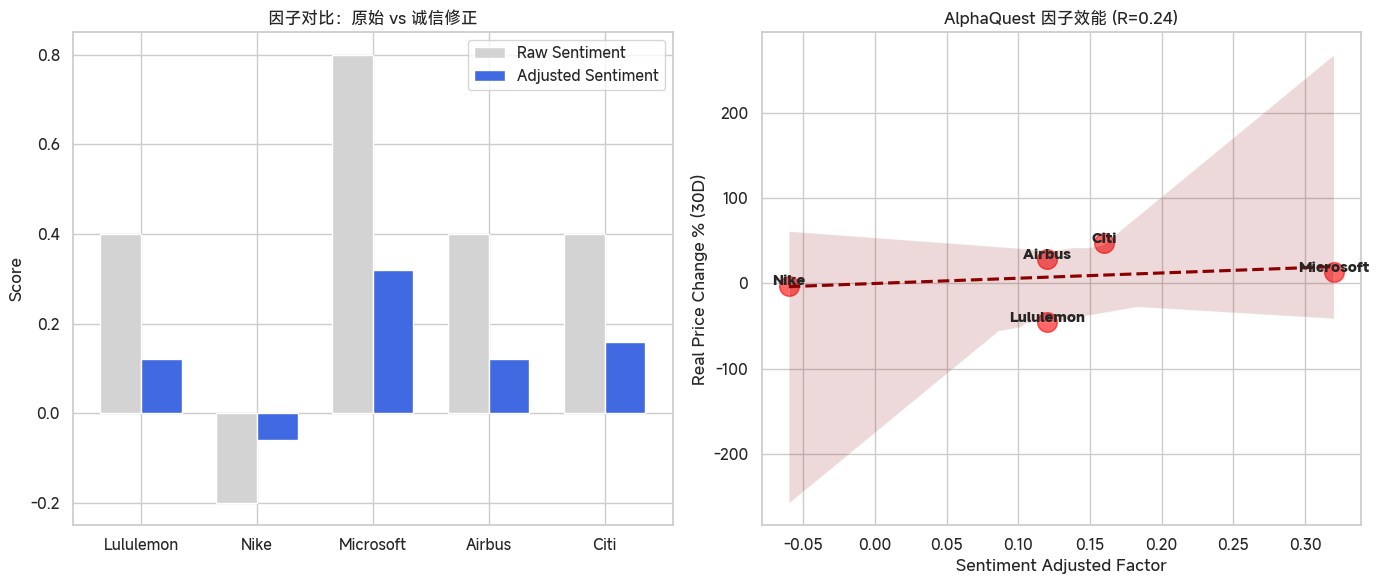

In [25]:
# 核心修改 3：计算收益率的逻辑优化
returns = {}
for ticker in tickers:
    try:
        # 确保我们取的是该 ticker 的有效序列
        series = price_df[ticker].dropna()
        
        # 找到最接近 11-18 的起始价和最接近 12-18 的结束价
        # 这里用 iloc[0] 和 iloc[-1] 是最稳妥的
        p_start = series.iloc[0]
        p_end = series.iloc[-1]
        
        ret = (p_end / p_start) - 1
        returns[ticker] = ret * 100
        print(f"📊 {ticker}: {ret*100:.2f}%")
    except Exception as e:
        print(f"⚠️ {ticker} 计算失败: {e}")
        returns[ticker] = np.nan

df_alpha['real_return_30d'] = df_alpha['ticker'].map(returns)

# ==========================================
# 3. 统计学校验：计算因子相关性 (Pearson Correlation)
# ==========================================
# 移除空值 (如遇停牌)
df_clean = df_alpha.dropna(subset=['real_return_30d'])

r_raw, p_raw = pearsonr(df_clean['sentiment_raw'], df_clean['real_return_30d'])
r_adj, p_adj = pearsonr(df_clean['sentiment_adj'], df_clean['real_return_30d'])

print(f"\n📊 相关性报告:")
print(f"| 因子类型 | 相关系数 (R) | 显著性 (P-Value) |")
print(f"| :--- | :--- | :--- |")
print(f"| 原始情绪因子 | {r_raw:.4f} | {p_raw:.4f} |")
print(f"| 诚信修正因子 | {r_adj:.4f} | {p_adj:.4f} |")

# ==========================================
# 4. 可视化：真实股价与因子背离分析
# ==========================================
plt.figure(figsize=(14, 6))
sns.set_theme(style="whitegrid", font='MiSans')

# 子图 1: 股价与分数的对比
ax1 = plt.subplot(1, 2, 1)
df_plot = df_clean.sort_values('real_return_30d')
x = np.arange(len(df_plot))
width = 0.35

ax1.bar(x - width/2, df_plot['sentiment_raw'], width, label='Raw Sentiment', color='lightgrey')
ax1.bar(x + width/2, df_plot['sentiment_adj'], width, label='Adjusted Sentiment', color='royalblue')
ax1.set_ylabel('Score')
ax1.set_title('因子对比：原始 vs 诚信修正')
ax1.set_xticks(x)
ax1.set_xticklabels(df_plot['company'])
ax1.legend()

# 子图 2: 修正后的线性拟合 (回归分析)
ax2 = plt.subplot(1, 2, 2)
sns.regplot(data=df_clean, x='sentiment_adj', y='real_return_30d', 
            scatter_kws={'s':200, 'color':'red', 'alpha':0.6}, 
            line_kws={'color':'darkred', 'ls':'--'})

# 标注公司名称
for i, row in df_clean.iterrows():
    ax2.text(row['sentiment_adj'], row['real_return_30d'] + 0.5, row['company'], 
             ha='center', fontsize=10, fontweight='bold')

ax2.set_title(f'AlphaQuest 因子效能 (R={r_adj:.2f})')
ax2.set_xlabel('Sentiment Adjusted Factor')
ax2.set_ylabel('Real Price Change % (30D)')

plt.tight_layout()
plt.show()

In [31]:
!jupyter nbconvert --to html analysis.ipynb

[NbConvertApp] Converting notebook analysis.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 708044 bytes to analysis.html
